## Get Started HEART

__Description__:

This notebook demonstrates how to get started with __HEART__

__Intended Audience__: All T&E users


## Contents:
1. Installation
2. Import library
3. Load a model
4. Load a dataset
5. Train a model
6. Define and execute an attack
7. Evaluate the result

## 1. Installation

If using HTTPS with Personal Access Token, use the following command

```bash
pip install git+https://gitlab.jatic.net/jatic/ibm/hardened-extension-adversarial-robustness-toolbox.git
```

If using SSH to install, do the following:

1. Update the conda lock file as appropriate to replace HTTPS install process with SSH install process

2. Use the following pip command:

```
pip install git+ssh://git@gitlab.jatic.net:jatic/ibm/hardened-extension-adversarial-robustness-toolbox.git
```

## 2. Import library
- import heart and verify the version
- also note the version of open-source ART

In [1]:
import heart_library
print("JATIC Specific Package Extension on Open-Source Art Version:", heart_library.__version__)

import art
print("Open-Source Art Version:", art.__version__)

JATIC Specific Package Extension on Open-Source Art Version: 0.3.3
Open-Source Art Version: 1.17.1


## 3. Load a model
- example of loading a pretrained model using __maite__

In [2]:
import torch
import os
import numpy as np
from heart_library.estimators.classification.pytorch import JaticPyTorchClassifier

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

path = '../'

class Model(torch.nn.Module):
        """
        Create model for pytorch.
        Here the model does not use maxpooling. Needed for certification tests.
        """

        def __init__(self):
            super(Model, self).__init__()

            self.conv = torch.nn.Conv2d(
                in_channels=3, out_channels=16, kernel_size=(4, 4), dilation=(1, 1), padding=(0, 0), stride=(3, 3)
            )

            self.fullyconnected = torch.nn.Linear(in_features=1600, out_features=10)

            self.relu = torch.nn.ReLU()

            w_conv2d = np.load(
                os.path.join(
                    os.path.dirname(path),
                    "utils/resources/models",
                    "W_CONV2D_NO_MPOOL_CIFAR10.npy",
                )
            )
            b_conv2d = np.load(
                os.path.join(
                    os.path.dirname(path),
                    "utils/resources/models",
                    "B_CONV2D_NO_MPOOL_CIFAR10.npy",
                )
            )
            w_dense = np.load(
                os.path.join(
                    os.path.dirname(path),
                    "utils/resources/models",
                    "W_DENSE_NO_MPOOL_CIFAR10.npy",
                )
            )
            b_dense = np.load(
                os.path.join(
                    os.path.dirname(path),
                    "utils/resources/models",
                    "B_DENSE_NO_MPOOL_CIFAR10.npy",
                )
            )

            self.conv.weight = torch.nn.Parameter(torch.Tensor(w_conv2d))
            self.conv.bias = torch.nn.Parameter(torch.Tensor(b_conv2d))
            self.fullyconnected.weight = torch.nn.Parameter(torch.Tensor(w_dense))
            self.fullyconnected.bias = torch.nn.Parameter(torch.Tensor(b_dense))

        # pylint: disable=W0221
        # disable pylint because of API requirements for function
        def forward(self, x):
            """
            Forward function to evaluate the model
            :param x: Input to the model
            :return: Prediction of the model
            """
            x = self.conv(x)
            x = self.relu(x)
            x = x.reshape(-1, 1600)
            x = self.fullyconnected(x)
            x = torch.nn.functional.softmax(x, dim=1)
            return x

# Define the network
model = Model()

# Define a loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Get classifier
# Note that clip values are set at 0-250, this is the pixel range prior to preprocessing (which normalizes between 0-1)
# therefore the attack will return adversarial images in the range 0-255, and epsilon and epsilon_step should be 
# set accordingly
classifier = JaticPyTorchClassifier(
    model=model, loss=loss_fn, optimizer=optimizer, input_shape=(3, 32, 32),
    nb_classes=10, clip_values=(0, 255), channels_first=False,
    preprocessing=(0.0, 255)
)

## 4. Load a dataset

In [3]:
from datasets import load_dataset

data = load_dataset("cifar10", split="test[0:10]")

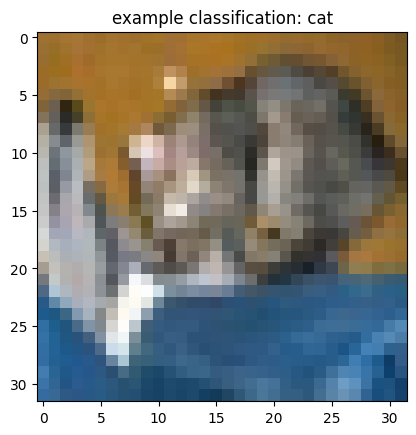

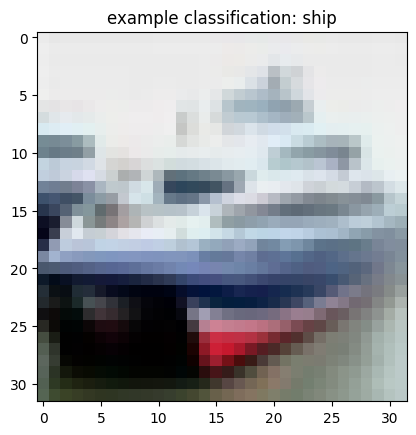

In [4]:
import matplotlib.pyplot as plt

predictions = np.argmax(classifier(data), axis=1)
for i, pred in enumerate(predictions[:2]):
    plt.imshow(np.asarray(data.__getitem__(i)['img']))
    plt.title(f'example classification: {labels[pred]}')
    plt.show()

Files already downloaded and verified


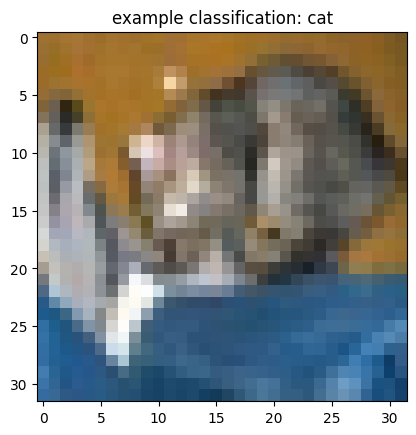

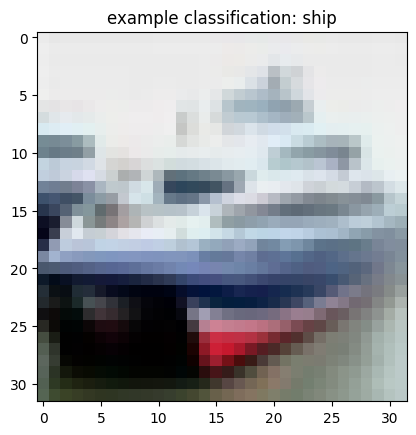

In [5]:
import torchvision

data = torchvision.datasets.CIFAR10("../data", train=False, download=True)
data = torch.utils.data.Subset(data, list(range(10)))

predictions = np.argmax(classifier(data), axis=1)
for i, pred in enumerate(predictions[:2]):
    plt.imshow(np.asarray(data.__getitem__(i)[0]))
    plt.title(f'example classification: {labels[pred]}')
    plt.show()

## 6. Define and execute an attack

In [6]:
from art.attacks.evasion import ProjectedGradientDescentPyTorch
from heart_library.attacks.attack import JaticAttack

predictions = classifier(data)

attack = JaticAttack(ProjectedGradientDescentPyTorch(estimator=classifier, norm=np.inf,
            eps=8,
            eps_step=2,
            max_iter=2000, targeted=False), norm=2)

x_test_adv, _, meta = attack(data=data)

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

## 7. Evaluate the result

{'clean_accuracy': 0.8, 'robust_accuracy': 0.0, 'mean_delta': 421.14365}


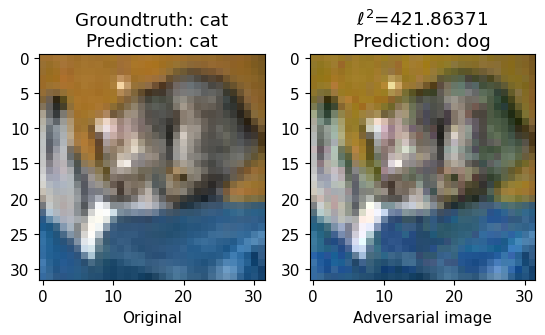

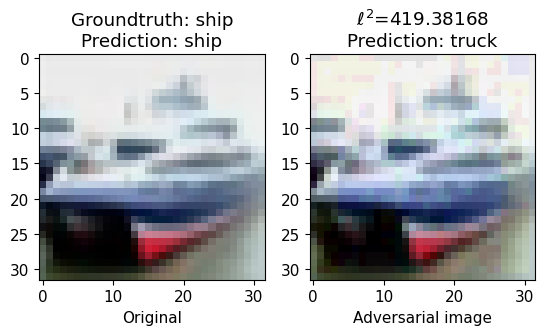

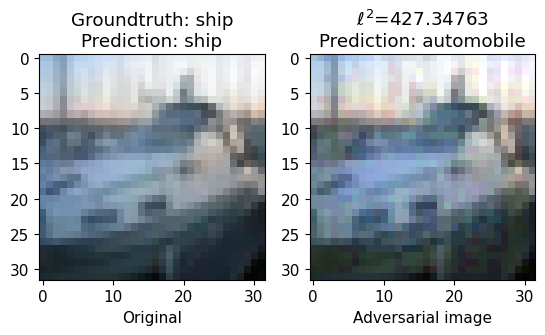

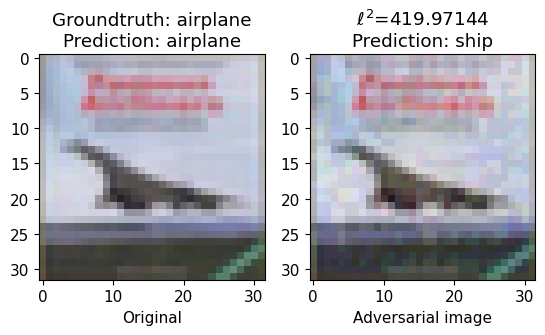

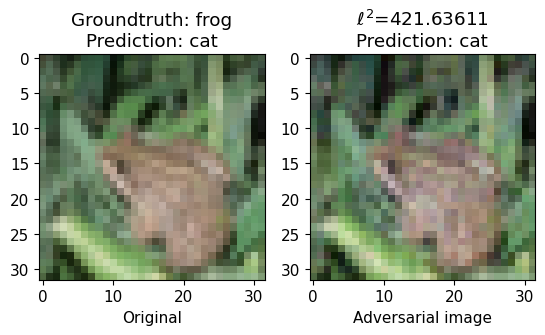

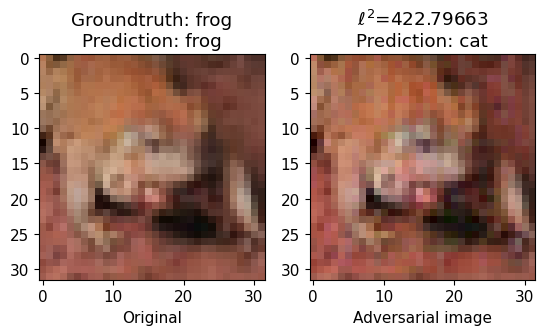

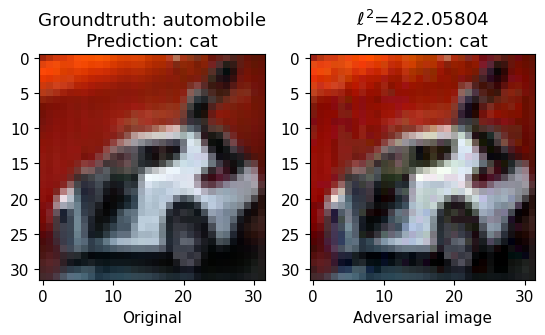

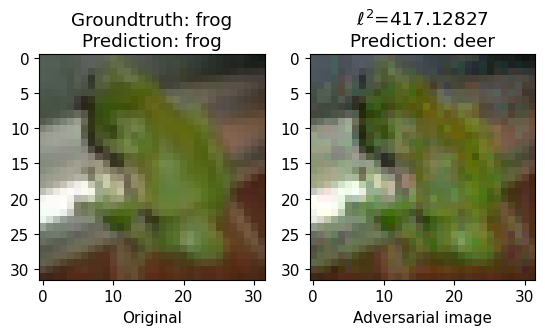

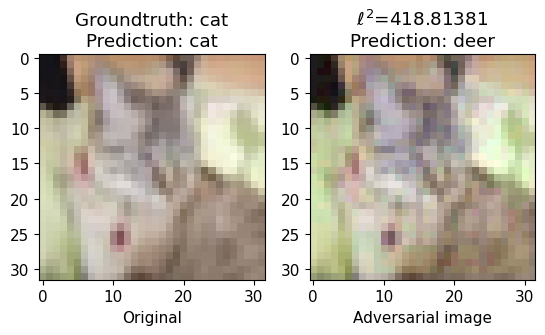

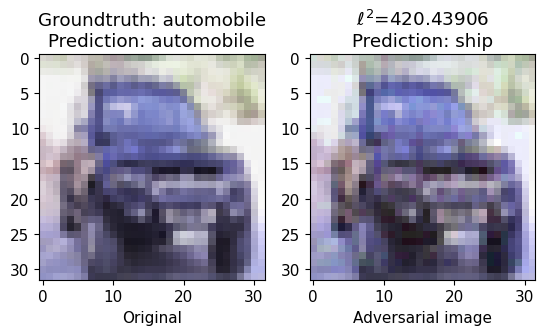

In [ ]:
import matplotlib.pyplot as plt
from heart_library.metrics import AccuracyPerturbationMetric
%matplotlib inline

groundtruth_target = np.asarray([item[1] for item in data])

metric = AccuracyPerturbationMetric(classifier(data), meta)
metric.update(classifier(x_test_adv), groundtruth_target)
print(metric.compute())

for i in range(10):
    f, ax = plt.subplots(1,2)
    
    norm_orig_img = (np.asarray(data.__getitem__(i)[0]).transpose(2,0,1)).astype(np.float32)
    perturbation = np.linalg.norm(norm_orig_img - x_test_adv[i])

    ax[0].set_title(f'Groundtruth: {labels[data.__getitem__(i)[1]]}\nPrediction: {labels[np.argmax(classifier(norm_orig_img))]}')
    ax[0].imshow(norm_orig_img.transpose(1,2,0).astype(np.uint8))
    ax[0].set_xlabel('Original')

    ax[1].set_title(f'$\\ell ^{2}$={perturbation:.5f}\nPrediction: {labels[np.argmax(classifier(x_test_adv[i]))]}')
    ax[1].imshow(x_test_adv[i].transpose(1,2,0).astype(np.uint8))
    ax[1].set_xlabel('Adversarial image')
    plt.show()